In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans

# Compile the Cython modules with 
# python setup.py build_ext --inplace
from tsp import tsp_path_solver as c_tsp_path_solver
from tsp import lagging_neighbor_path_py 

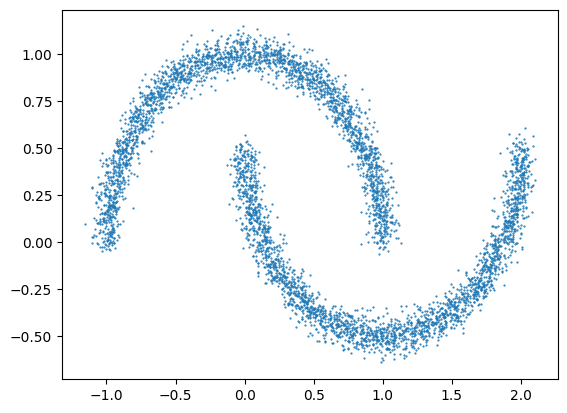

In [2]:
n = 5000
rs = 1337

# Get some sample data
noisy_moons = datasets.make_moons(n_samples=n, noise=0.05, random_state=rs)
points = noisy_moons[0]

fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], s=0.3)

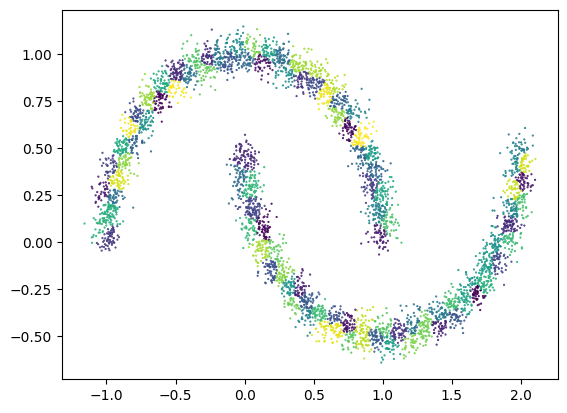

In [3]:
# Run KMeans clustering to coarse-grain the points
kmeans = KMeans(n_clusters=round(len(points) / 50 ), random_state=1337).fit(points)

# Notice that the points are un-ordered
fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], c=kmeans.labels_, s=0.3)

64 [-1.04896338  0.09079734]


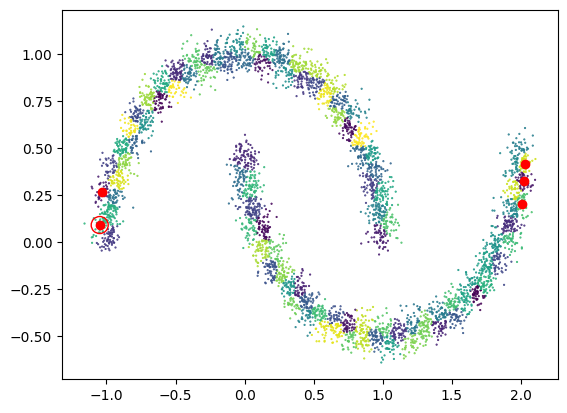

In [4]:
# Figure out an 'end' of the data
def neigborhood_anisotropy(centroids):
    # the ends of the structure have the most anisotropic neighborhoods
    # Use a simple linear falloff of the distance to weight neighbors more
    centroid_vectors = centroids[:, None] - centroids[None, :]
    with np.errstate(invalid='ignore'): # The norms of the diag are all 0
        centroid_vectors /= (2 * np.linalg.norm(centroid_vectors, axis=2))[:, :, None]
    np.nan_to_num(centroid_vectors, copy=False)
    aniso = np.sum(centroid_vectors, axis=1)
    aniso = np.linalg.norm(aniso, axis=1)
    return aniso

centroids = kmeans.cluster_centers_
aniso = neigborhood_anisotropy(centroids)
best = np.argpartition(aniso, -5)[-5:]

# Arbitrarily, let's pick the best one with the smallest x-coordinate
ref_idx = best[np.argmin(centroids[best][:,0])]
print(ref_idx, centroids[ref_idx])

fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], c=kmeans.labels_, s=0.3)
ax.scatter(centroids[best][:,0], centroids[best][:,1], c='r')
ax.scatter(centroids[ref_idx][0], centroids[ref_idx][1], s=150, facecolors='none', edgecolors='r')


Nearest neighbor path distance: 61.2925
Edge statistics - Min: 0.0812, Max: 2.3436, Avg: 0.6191


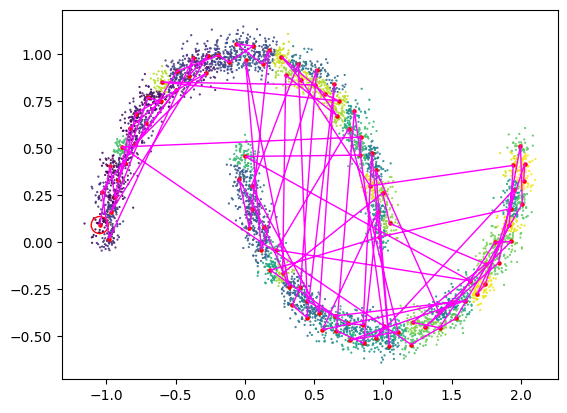

In [5]:
# Re-order centroids using the dumb lagging mean method
# This works okay when you have a single long blob (like RNA atoms)
centroids = centroids.astype(np.float64)
new_labels = lagging_neighbor_path_py(centroids, ref_idx) 

# Re-label the points
ordered_centroids = centroids[new_labels]
new_point_labels = np.array([np.argwhere(new_labels==l) for l in kmeans.labels_])

fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], c=new_point_labels, s=0.3)
ax.scatter(ordered_centroids[:,0], ordered_centroids[:,1], c='r', s=5)
ax.plot(ordered_centroids[:,0], ordered_centroids[:,1], c='magenta', linewidth=1)
ax.scatter(ordered_centroids[0][0], ordered_centroids[0][1], s=150, facecolors='none', edgecolors='r')


Solving TSP for 100 nodes starting from index 64
Step 1: Finding greedy nearest neighbor solution...
Nearest neighbor path distance: 61.2925
Edge statistics - Min: 0.0812, Max: 2.3436, Avg: 0.6191

Step 2: Running simulated annealing optimization...
Starting simulated annealing with initial cost: 61.2925
Iteration 0: Current cost = 61.2925, Best cost = 61.2925, Temperature = 1.232042, Longest step = 2.343559847960531 at position 70
Iteration 10000: Current cost = 17.0264, Best cost = 17.0264, Temperature = 0.000000, Longest step = 0.8301853790380509 at position 97
Iteration 20000: Current cost = 108.4715, Best cost = 15.6635, Temperature = 1.565092, Longest step = 2.738549427563099 at position 71
Iteration 30000: Current cost = 123.4369, Best cost = 15.6635, Temperature = 2.856079, Longest step = 2.9158156258844357 at position 73
Iteration 40000: Current cost = 109.8804, Best cost = 15.6635, Temperature = 5.211953, Longest step = 2.750685034606762 at position 20
Iteration 50000: Curren

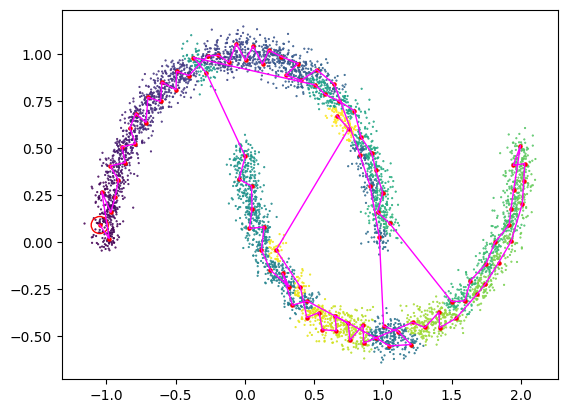

In [9]:
# Re-order centroids using simulated annealing to optimize the points
centroids = centroids.astype(np.float64)
new_labels = c_tsp_path_solver(centroids, ref_idx, max_iterations=10000000) 

# Re-label the points
ordered_centroids = centroids[new_labels]
new_point_labels = np.array([np.argwhere(new_labels==l) for l in kmeans.labels_])

fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], c=new_point_labels, s=0.3)
ax.scatter(ordered_centroids[:,0], ordered_centroids[:,1], c='r', s=5)
ax.plot(ordered_centroids[:,0], ordered_centroids[:,1], c='magenta', linewidth=1)
ax.scatter(ordered_centroids[0][0], ordered_centroids[0][1], s=150, facecolors='none', edgecolors='r')

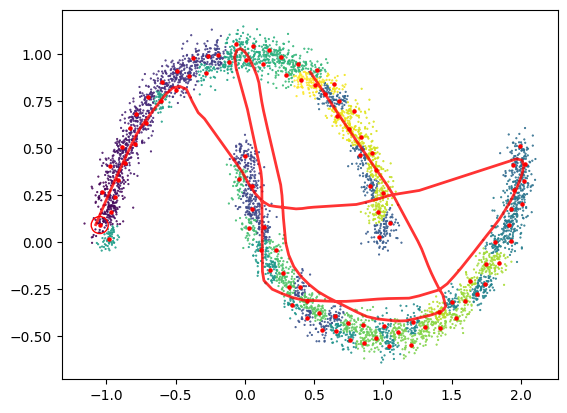

In [7]:
# This is 100% vibe-coded and have no idea how it works.  
# Seems to work well though
def fit_lowess_curve(points, frac=0.3, it=3, num_eval_points=100):
    """
    Fit a LOWESS (Locally Weighted Scatterplot Smoothing) curve to ordered 2D points.
    This finds a smooth center line through the data rather than interpolating through each point.
    
    Parameters:
    -----------
    points : array-like, shape (n_points, 3)
        Ordered sequence of 3D points
    frac : float, default=0.3
        Fraction of data points to use in each local regression (0 < frac <= 1)
        Smaller values = more local fitting, larger values = smoother curve
    it : int, default=3
        Number of robustness iterations to perform
    num_eval_points : int, default=100
        Number of points to evaluate the curve at
        
    Returns:
    --------
    curve_func : callable
        Function that takes parameter t and returns (x, y) coordinates
    eval_points : array, shape (num_eval_points, 2)
        Evaluated curve points for plotting
    t_eval : array, shape (num_eval_points,)
        Parameter values corresponding to eval_points
    """
    def _tricube_weight(u):
        """Tricube weight function for LOWESS"""
        u = np.abs(u)
        weights = np.zeros_like(u)
        mask = u < 1
        weights[mask] = (1 - u[mask]**3)**3
        return weights

    def _bisquare_weight(u):
        """Bisquare weight function for robustness iterations"""
        u = np.abs(u)
        weights = np.zeros_like(u)
        mask = u < 1
        weights[mask] = (1 - u[mask]**2)**2
        return weights

    def _weighted_regression(x, y, weights, x_eval):
        """Perform weighted linear regression and evaluate at x_eval"""
        if len(x) < 2:
            return np.mean(y)  # Fallback for edge cases
    
        # Create design matrix for linear regression (1, x)
        X = np.column_stack([np.ones(len(x)), x])

        # Weighted least squares solution
        W = np.diag(weights)
        try:
            XtWX_inv = np.linalg.inv(X.T @ W @ X)
            coeffs = XtWX_inv @ X.T @ W @ y

            # Evaluate at x_eval
            return coeffs[0] + coeffs[1] * x_eval
        except np.linalg.LinAlgError:
            # Fallback if matrix is singular
            return np.average(y, weights=weights)
        
    points = np.array(points)
    n_points = len(points)
    
    if n_points < 3:
        raise ValueError("Need at least 3 points for LOWESS fitting")
    
    # Parameterize points by cumulative distance
    distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
    t = np.zeros(n_points)
    t[1:] = np.cumsum(distances)
    
    # Normalize parameter to [0, 1] for easier handling
    t_normalized = t / t[-1] if t[-1] > 0 else t
    
    # Number of points to use in each local regression
    n_local = max(3, int(frac * n_points))
    
    # Initialize arrays for smoothed values
    smoothed_x = np.zeros(n_points)
    smoothed_y = np.zeros(n_points)
    residuals = np.zeros(n_points)
    weights = np.ones(n_points)
    
    # Perform LOWESS iterations
    for iteration in range(it):
        for i in range(n_points):
            # Find the n_local nearest neighbors in parameter space
            distances_to_i = np.abs(t_normalized - t_normalized[i])
            neighbor_indices = np.argsort(distances_to_i)[:n_local]
            
            # Calculate tricube weights based on distance in parameter space
            max_dist = np.max(distances_to_i[neighbor_indices])
            if max_dist > 0:
                tricube_weights = _tricube_weight(distances_to_i[neighbor_indices] / max_dist)
            else:
                tricube_weights = np.ones(n_local)
            
            # Combine with robustness weights
            combined_weights = tricube_weights * weights[neighbor_indices]
            
            # Fit local weighted linear regression for x and y separately
            t_local = t_normalized[neighbor_indices]
            
            # Fit x as function of t
            smoothed_x[i] = _weighted_regression(t_local, points[neighbor_indices, 0], 
                                               combined_weights, t_normalized[i])
            
            # Fit y as function of t  
            smoothed_y[i] = _weighted_regression(t_local, points[neighbor_indices, 1], 
                                               combined_weights, t_normalized[i])
        
        # Update robustness weights based on residuals
        if iteration < it - 1:
            residuals_x = points[:, 0] - smoothed_x
            residuals_y = points[:, 1] - smoothed_y
            residuals = np.sqrt(residuals_x**2 + residuals_y**2)
            median_residual = np.median(residuals)
            
            if median_residual > 0:
                weights = _bisquare_weight(residuals / (6 * median_residual))
            else:
                weights = np.ones(n_points)
    
    # Create interpolation function for the smoothed curve
    def curve_func(t_values):
        """Evaluate LOWESS curve at given parameter values"""
        # Normalize input parameter values
        t_input = np.atleast_1d(t_values)
        t_norm_input = t_input / t[-1] if t[-1] > 0 else t_input
        
        # Interpolate smoothed values
        x_interp = np.interp(t_norm_input, t_normalized, smoothed_x)
        y_interp = np.interp(t_norm_input, t_normalized, smoothed_y)
        
        if np.isscalar(t_values):
            return np.array([x_interp[0], y_interp[0]])
        else:
            return np.column_stack([x_interp, y_interp])
    
    # Evaluate curve for plotting
    t_eval = np.linspace(0, t[-1], num_eval_points)
    eval_points = curve_func(t_eval)
    
    return curve_func, eval_points, t_eval

curve_func, eval_points, t_eval = fit_lowess_curve(
            ordered_centroids, frac=0.2, num_eval_points=200
        )

fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], c=new_point_labels, s=0.3)
ax.scatter(ordered_centroids[:,0], ordered_centroids[:,1], c='r', s=5)
ax.plot(eval_points[:, 0], eval_points[:, 1], linewidth=2, c='r', alpha=0.8)
ax.scatter(ordered_centroids[0][0], ordered_centroids[0][1], s=150, facecolors='none', edgecolors='r')